### Importation packages

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
import multiprocessing
from multiprocessing import Pool, Process, Manager
from functools import partial
from PIL import Image

### Importation DATA

In [2]:
# Images informations
df_path = pd.read_csv("df_path.csv")
print(df_path.shape)
df_path.head()

(480, 9)


,PLATE_ID,WellID,X_POSITION,Y_POSITION,T_INDEX,Z_INDEX,SOURCE_DESCRIPTION,PATH,ImgID
0,22931,C03,1.0,1.0,1,1,Transmitted Light 50,/media/Hcs-screen10-vi/MDStorage_17/SAMSARA-ST...,22931_C03_1_1
1,22931,C03,2.0,1.0,1,1,Transmitted Light 50,/media/Hcs-screen10-vi/MDStorage_17/SAMSARA-ST...,22931_C03_2_1
2,22931,C03,1.0,2.0,1,1,Transmitted Light 50,/media/Hcs-screen10-vi/MDStorage_17/SAMSARA-ST...,22931_C03_1_2
3,22931,C03,2.0,2.0,1,1,Transmitted Light 50,/media/Hcs-screen10-vi/MDStorage_17/SAMSARA-ST...,22931_C03_2_2
4,22931,D03,1.0,1.0,1,1,Transmitted Light 50,/media/Hcs-screen10-vi/MDStorage_17/SAMSARA-ST...,22931_D03_1_1


In [3]:
# Labelling information
NFT = pd.read_csv("NFT.csv")
print(NFT.shape)
NFT.head()

(127791, 11)


,cx,cy,DAPI_ity,FITC_ity,FITC_sd,is_dead,PlateID,WellID,sxy,CellID,ImgID
0,1619,1777,1.000000,0.351443,0.030059,1,22931,C03,"[1, 1]",0,22931_C03_1_1
1,454,1921,0.764468,0.344118,0.053073,1,22931,C03,"[1, 1]",1,22931_C03_1_1
2,1300,1593,0.162307,0.401410,0.028979,0,22931,C03,"[1, 1]",2,22931_C03_1_1
3,438,461,1.000000,0.400738,0.097090,1,22931,C03,"[1, 1]",3,22931_C03_1_1
4,326,1675,0.480760,0.374527,0.028418,0,22931,C03,"[1, 1]",4,22931_C03_1_1


### Dataset distribution

Text(0.5, 1.0, 'Labels distribution')

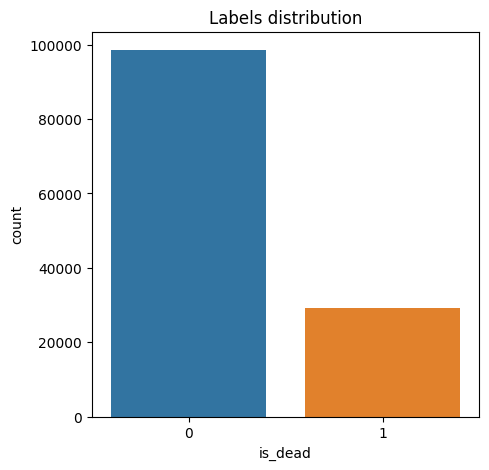

In [4]:
plt.figure(figsize=(5,5))
sb.countplot(data=NFT, x= "is_dead")
plt.title("Labels distribution")

### Dataset splitting

In [5]:
train,val = train_test_split(df_path,test_size = 0.2, random_state = 42)
print("train",train.shape)
print("val",val.shape)
train.to_csv("train_part.csv", index_label = False)
val.to_csv("val_part.csv", index_label= False)

train (384, 9)
val (96, 9)


### Dataset creation

In [6]:
# Pading function for image size standardization
def Pad(img, new_shape) :
    pad = (new_shape-img.shape[0])//2
    m = np.zeros((new_shape,new_shape))
    if pad > 0 :
        m[pad:img.shape[0]+pad,pad:img.shape[1]+pad:] = img
    else : 
        pad = abs(pad)
        m = img[pad : pad+new_shape,pad : pad+new_shape,]
    return m


# Image Normalization function
def AutoNormalize(img, q = [0.0005,0.9995]) :
    matrix = img / 2**16
    quantile = np.quantile(matrix,q)
    matrix_scaled = (matrix - quantile[0]) /(quantile[1]-quantile[0])
    matrix_scaled[matrix_scaled <0] = 0
    matrix_scaled[matrix_scaled >1] = 1
    return matrix_scaled

# Dataset making function
def Dataset_yolo(index) :
    row = df_path.iloc[index]
    p = row.PLATE_ID
    w = row.WellID
    sxy = (int(row.X_POSITION), int(row.Y_POSITION))
    ImgID = row.ImgID
    path_ = row.PATH
    img = np.array(Image.open(path_))
    img = Pad(img, 2048)
    #
    img = AutoNormalize(img)
    ishape = img.shape[0]

    img = Image.fromarray((img*255).astype("uint8")).convert("L")
    img.save(img_output_path+str(index).zfill(4)+".png")
    
    ###labels
    lab = NFT[NFT.ImgID == ImgID]
    lab = lab[["is_dead","cy","cx"]]
    lab.cy = lab.cy / ishape
    lab.cx = lab.cx / ishape
    lab["W"] = 50/ ishape
    lab["H"] = 50/ ishape
    lab.to_csv(label_output_path+str(index).zfill(4)+".txt", header=None, index=None, sep=' ', mode='a')

In [29]:
# Train part making
img_output_path = "datasets/images/train/"
label_output_path="datasets/labels/train/"


os.makedirs(img_output_path,exist_ok=True)
os.makedirs(label_output_path,exist_ok=True)


x = list(train.index)

#
if __name__ == '__main__':
    with Pool(multiprocessing.cpu_count()) as pool:
        pool.map(partial(Dataset_yolo),x)

In [34]:
# Val part making
img_output_path = "datasets/images/val/"
label_output_path="datasets/labels/val/"


os.makedirs(img_output_path,exist_ok=True)
os.makedirs(label_output_path,exist_ok=True)


x = list(val.index)

#
if __name__ == '__main__':
    with Pool(multiprocessing.cpu_count()) as pool:
        pool.map(partial(Dataset_yolo),x)